<a href="https://colab.research.google.com/github/kenichinakanishi/houseplant_classifier/blob/master/Part_4_TorchVision_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
# Check GPU on Colabs
# NVIDIA-SMI 455.32.00 Driver Version: 418.67 CUDA Version: 10.1 Tesla V100-SXM2
! nvidia-smi 

Mon Nov 30 23:51:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Run once per session
!pip install fastai==2.1.2 -q
!pip install fastcore==1.3.1 -q
!pip install torch==1.7.0 -q
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.callback.cutmix import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *
from fastcore.script import *
fastprogress.MAX_COLS = 80

     |████████████████████████████████| 194kB 14.5MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 


In [4]:
# Import source of efficientnet models and weights
!pip install geffnet -q
import geffnet

! pip install pytorchcv torch>=0.4.0 -q
from pytorchcv.model_provider import get_model as ptcv_get_model

In [5]:
torch.cuda.is_available()

True

In [6]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil -q
!pip install psutil -q
!pip install humanize -q
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [7]:
printm()

Gen RAM Free: 26.3 GB  | Proc size: 307.7 MB
GPU RAM Free: 16120MB | Used: 10MB | Util   0% | Total 16130MB


# Download and Unzip the File

The use of images directly from a google drive is very slow.
This is because even though the drive appears to be direcly attached to our colab instance, in actuality we are dynamically downloading and accessing each image one by one - leading to extremely long training times. 

At this point, I've gone to the directory the image files were downloaded to, zipped them up and placed that master zip file into my google drive for importing and processing. 

In [8]:
# If your zip file is on your google drive - download it into the current kernel
!cp '/content/drive/My Drive/Houseplant Classifier/plant_images_database_manualcleanedlosses10.zip' 'plant_images_database_manualcleanedlosses10.zip'
# This code snippet unzips a zip file to a specified destination
!unzip -q "/content/plant_images_database_manualcleanedlosses10.zip" -d "/content";

plant_images_database_manualcleanedlosses10/Citrus ×aurantium/:  mismatching "local" filename (plant_images_database_manualcleanedlosses10/Citrus ├Чaurantium/),
         continuing with "central" filename version
plant_images_database_manualcleanedlosses10/Citrus ×aurantium/00000000.jpg:  mismatching "local" filename (plant_images_database_manualcleanedlosses10/Citrus ├Чaurantium/00000000.jpg),
         continuing with "central" filename version
plant_images_database_manualcleanedlosses10/Citrus ×aurantium/00000001.jpg:  mismatching "local" filename (plant_images_database_manualcleanedlosses10/Citrus ├Чaurantium/00000001.jpg),
         continuing with "central" filename version
plant_images_database_manualcleanedlosses10/Citrus ×aurantium/00000002.jpg:  mismatching "local" filename (plant_images_database_manualcleanedlosses10/Citrus ├Чaurantium/00000002.jpg),
         continuing with "central" filename version
plant_images_database_manualcleanedlosses10/Citrus ×aurantium/00000003.jpg: 

In [9]:
# If your zip file is on your google drive - download it into the current kernel
!cp '/content/drive/My Drive/Houseplant Classifier/plant_images_database.zip' 'plant_images_database.zip'
# This code snippet unzips a zip file to a specified destination
!unzip -q "/content/plant_images_database.zip" -d "/content";

plant_image_database/Citrus ×aurantium/:  mismatching "local" filename (plant_image_database/Citrus ├Чaurantium/),
         continuing with "central" filename version
plant_image_database/Citrus ×aurantium/00000000.jpg:  mismatching "local" filename (plant_image_database/Citrus ├Чaurantium/00000000.jpg),
         continuing with "central" filename version
plant_image_database/Citrus ×aurantium/00000001.jpg:  mismatching "local" filename (plant_image_database/Citrus ├Чaurantium/00000001.jpg),
         continuing with "central" filename version
plant_image_database/Citrus ×aurantium/00000002.jpg:  mismatching "local" filename (plant_image_database/Citrus ├Чaurantium/00000002.jpg),
         continuing with "central" filename version
plant_image_database/Citrus ×aurantium/00000003.jpg:  mismatching "local" filename (plant_image_database/Citrus ├Чaurantium/00000003.jpg),
         continuing with "central" filename version
plant_image_database/Citrus ×aurantium/00000004.jpg:  mismatching "lo

# Set Up Model

In [10]:
def random_seed(seed_value, use_cuda):
  '''
  Sets the random seed for numpy, pytorch, python.random and pytorch GPU vars.
  '''
  np.random.seed(seed_value) # Numpy vars
  torch.manual_seed(seed_value) # PyTorch vars
  random.seed(seed_value) # Python
  if use_cuda: # GPU vars
      torch.cuda.manual_seed(seed_value)
      torch.cuda.manual_seed_all(seed_value) 
      torch.backends.cudnn.deterministic = True 
      torch.backends.cudnn.benchmark = False
  print(f'Random state set:{seed_value}, cuda used: {use_cuda}')

In [11]:
@call_parse
def create_path_df(
      path: Param("Path of images to use", str), 
      pct_images: Param("Fraction of images to use", float)=1,
      shuffle: Param("Shuffle prior to splitting", bool)=False,
      ):
  '''
  Creates a dataframe with respective classes and path to images.
  Can return a subset of those images based on the pct_images.
  By default will return the earliest files in the path.

  Returns:
  ----------
  DataFrame
    Returns a dataframe with Class and Path columns. 
  '''
  from sklearn.utils import shuffle as shuff
  data = []
  for folder in sorted(os.listdir(path)):
      num_files = len(sorted(os.listdir(path+'/'+folder)))
      cut_point = int(num_files*pct_images)
      # Takes the first pct_images from each folder
      if shuffle == True:
        for file in shuff(os.listdir(path+'/'+folder))[:cut_point]:
          data.append((folder, path+folder+'/'+file))
      else:
        for file in sorted(os.listdir(path+'/'+folder))[:cut_point]:
          data.append((folder, path+folder+'/'+file))
  df = pd.DataFrame(data, columns=['Class', 'Path'])
  print(f'Creating path:label dataframe from {path}, using {pct_images*100:.2f}% of the images ({len(df)} images.) Shuffle = {shuffle}.')
  return df

In [12]:
@call_parse
def stratified_split(
      dataframe: Param("DataFrame created from create_path_df, containing Class and Path columns."), 
      n_splits: Param("Number of folds in split", int)=5,
      shuffle: Param("Shuffle prior to splitting", bool)=True,
      fold: Param("Which fold to use", int)=0,
      random_state: Param("Fix randomness if shuffle==True", int)=101,
      ):
  ''' 
  Prepares a stratified k-fold split from a dataframe with 'Class' and 'Path' by adding an 'is_valid' column.

  Returns:
  ----------
  DataFrame
    Returns the requested stratified k-fold split by adding an 'is_valid' column. 
  '''
  from sklearn.model_selection import StratifiedKFold
  # Create stratified split using sklearn
  print(f'Preparing stratified {n_splits} fold split, random state is {random_state}. Returning fold {fold}.')
  kf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state = random_state)
  X, y = dataframe['Path'], dataframe['Class']
  splits = list(kf.split(X, y))
  # Prepare the selected fold
  fold = fold
  train_df = dataframe.loc[splits[fold][0]]
  val_df = dataframe.loc[splits[fold][1]]
  train_df['is_valid'] = False
  val_df['is_valid'] = True
  df_cnn = train_df.append(val_df)
  # Return the selected fold
  return df_cnn

In [13]:
@call_parse
def get_dataloader(
      img_path: Param("Path of images to use", str),
      split_path: Param("Path of images to use to pre-define split", str)=None,
      img_size:  Param("Size in pixels", int)=224,
      pct_images: Param("Fraction of images to use", float)=1,
      bs: Param("Batch size", int)=64,
      deterministic: Param("Deterministic learner", bool)=True,
      randomerasing: Param("Random Erasing", str)=None,
      n_splits: Param("Number of folds in split", int)=5,
      shuffle: Param("Shuffle prior to splitting", bool)=True,
      fold: Param("Which fold to use", int)=0,
      ):
  """ 
  Takes in image path and creates a dataloader. 
  If a split_path is defined, uses the entirety of that path to generate a master split, onto which the img_path is joined to defined a pseudo split.  
      
  Returns:
  ----------
  Dataloader
    dls = data.dataloaders(df_cnn_mini, bs=bs)
  """

  # Get file path and labels from the dataframe we set up.
  get_x = lambda x: x['Path']
  get_y = lambda y: y['Class']
  # Define splitting function that reads from a dataframe column.
  def stratifiedsplitter(df):      
      train = df.index[~df['is_valid']].tolist()
      valid = df.index[df['is_valid']].tolist()
      return train,valid   
  # Prepare transforms
    # Image is larger initially (512 px) for later augmentations.
  item_tfms=[RandomResizedCrop(512, min_scale = 0.7)]
    # Batch transformations include a random resized crop to img_size px. 
  batch_tfms=[*aug_transforms(size=img_size), Normalize.from_stats(*imagenet_stats)]
  # Add in randomerasing if necessary.
  if randomerasing != None:
    batch_tfms=[*aug_transforms(size=img_size), Normalize.from_stats(*imagenet_stats), randomerasing]
  # Prepare DataBlock
  data = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    splitter=stratifiedsplitter,            # Stratified train/validation split
                    get_x=get_x,                            # Get the image path from dataframe
                    get_y=get_y,                            # Label from dataframe
                    item_tfms=item_tfms,                    # Crop images to a square
                    batch_tfms=batch_tfms)                  # Normalize the images based on the imagenet stats
  if split_path != None:
    print('Split Path defined, preparing pseudo stratified split.')
    # Create split_df - a dataframe that defines a master split, based on split_path
    df = create_path_df(split_path, pct_images=1)
    split_df = stratified_split(df, n_splits = 5, shuffle = True, random_state = 101, fold = 0)
    split_df['Path']= split_df['Path'].apply(lambda x:img_path+'/'.join(x.split('/')[-2:]))
    # Inner join this reduced dataframe to the previous splits to maintain the same training images
    df_mini = create_path_df(img_path, pct_images=pct_images)
    df_cnn_mini= df_mini.merge(split_df, how = 'inner', on = ['Class','Path'])
  else: 
    # Create a dataframe based on main image path with a (possibly) reduced number of images
    df = create_path_df(img_path, pct_images=pct_images)
    df_cnn_mini = stratified_split(df, n_splits = 5, shuffle = True, random_state = 101, fold = 0)
  # Print some information for a sanity check
  dls = data.dataloaders(df_cnn_mini, bs=bs)
  print(f'We have {dls.c} classes, with a training set of size {len(dls.train_ds)}, and a validation set of size {len(dls.valid_ds)}')
  if split_path != None:
    print(f"The main split has {split_df['is_valid'].describe()['freq']/len(split_df['is_valid'])*100:.2f}% training data with {len(split_df.groupby('Class').count())} classes, the reduced split has {df_cnn_mini['is_valid'].describe()['freq']/len(df_cnn_mini['is_valid'])*100:.2f} % training data, with {len(df_cnn_mini.groupby('Class').count())} classes.")
  return dls

In [14]:
@call_parse
def create_simple_cnn_learner(
        size:  Param("Size", int)=224,
        bs:    Param("Batch size", int)=64,
        arch:  Param("Architecture", str)='resnet34',
        fp16:  Param("Use mixed precision training", int)=0,
        deterministic: Param("Deterministic learner", bool)=True,
        pretrained: Param("Pretrained architecture", bool)=True,
        pct_images: Param("Percent of images to sue", float)=1,
        img_path: Param("Path of images to use", str)='/content/plant_images_database_manualcleanedlosses10/',
        split_path: Param("Path of images to use to pre-define split", str)=None,
        model_dir: Param("Path to save model", str)='/content/drive/My Drive/Houseplant Classifier/Models/',
        log_name: Param("Name of csv training log", str)='history.csv',
        ):
    # Select optimization function
    opt_func = partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)
    # Set Random Seed
    if deterministic == True:
      random_seed(101,True)
    # Get Dataloader
    dls = get_dataloader(img_size = size, bs = bs, img_path=img_path, split_path=split_path, pct_images=pct_images)
    # Setup activation function and pooling
    model = globals()[arch] 
    # Setup callbacks
    callbacks = [CSVLogger(fname=log_name, append=True), ShowGraphCallback()]
    # Setup Learner
    learn = cnn_learner(dls, 
                        model, 
                        pretrained=pretrained,
                        opt_func=opt_func,
                        metrics=[accuracy,top_k_accuracy], 
                        model_dir = model_dir,
                        cbs=callbacks,
                        )
    if fp16: learn = learn.to_fp16()

    return learn

In [15]:
@call_parse
def create_cnn_learner(
        size:  Param("Size", int)=224,
        bs:    Param("Batch size", int)=64,
        opt:   Param("Optimizer (adam,rms,sgd,ranger)", str)='adam',
        arch:  Param("Architecture", str)='resnet34',
        custom_head:  Param("Use of custom head", nn.Sequential)=None,
        fp16:  Param("Use mixed precision training", int)=0,
        deterministic: Param("Deterministic learner", bool)=True,
        pretrained: Param("Pretrained architecture", bool)=True,
        pct_images: Param("Percent of images to sue", float)=1,
        img_path: Param("Path of images to use", str)='/content/plant_images_database_manualcleanedlosses10/',
        split_path: Param("Path of images to use to pre-define split", str)=None,
        model_dir: Param("Path to save model", str)='/content/drive/My Drive/Houseplant Classifier/Models/',
        log_name: Param("Name of csv training log", str)='history.csv',
        loss_func: Param("Learner loss function", str)=None,
        mixup: Param("Mixup", str)=None,
        cutmix: Param("Cutmix", str)=None,
        randomerasing: Param("Random Erasing", str)=None,
        ):
    # Select optimization function
    if   opt=='adam'  : opt_func = partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)
    elif opt=='rms'   : opt_func = partial(RMSprop, sqr_mom=0.99, mom=0.0, wd=0.0, decouple_wd=True)
    elif opt=='sgd'   : opt_func = partial(SGD, mom=0.0, wd=0.0, decouple_wd=True)
    elif opt=='ranger': opt_func = partial(ranger, mom=0.95, wd=0.01, eps=1e-06, sqr_mom=0.99, beta=0.0, decouple_wd=True)
    # Get DataLoader
    if deterministic == True:
      random_seed(101,True)
    # Implement RandomErasing
    if randomerasing != None:
      dls = get_dataloader(img_size = size, bs = bs, img_path=img_path, split_path=split_path, pct_images=pct_images, randomerasing=randomerasing)
    else: 
      dls = get_dataloader(img_size = size, bs = bs, img_path=img_path, split_path=split_path, pct_images=pct_images)
    # Setup activation function and pooling
    model = globals()[arch] 
    # Setup callbacks
    callbacks = [CSVLogger(fname=log_name, append=True), ShowGraphCallback()]
    if mixup != None:
      mixup = mixup
      callbacks = [CSVLogger(fname=log_name, append=True), ShowGraphCallback(), mixup]
    elif cutmix != None:
      cutmix = cutmix
      callbacks = [CSVLogger(fname=log_name, append=True), ShowGraphCallback(), cutmix]
    # Setup Learner
    learn = cnn_learner(dls, 
                        model, 
                        pretrained=pretrained,
                        config = {'custom_head':custom_head},
                        opt_func=opt_func,
                        metrics=[accuracy,top_k_accuracy], 
                        model_dir = model_dir,
                        loss_func = loss_func,
                        cbs=callbacks,
                        )
    if fp16: learn = learn.to_fp16()

    return learn

In [16]:
def enumerate_params(learner):
  '''
  Enumerates the unfrozen and frozen parameters for a given learner when called.
  '''
  total_params = sum(p.numel() for p in learner.model.parameters())
  print(f'{total_params:,} total parameters.')
  total_trainable_params = sum(
  p.numel() for p in learner.model.parameters() if p.requires_grad)
  print(f'{total_trainable_params:,} training parameters.')

# Enable Model Modification

In [18]:
def change_act(model, pre_act, post_act):
  # We want to go down each 'level' of the model and search for each activation, changing them to the activation we want to use.
    # We can access the named_children of the model and use that to index our way into the appropriate layers
    # pre_act is a class
    # EfficientNet - geffnet.activations_me.SwishMe
    # ResNet - torch.nn.modules.activation.ReLU
    # post_act examples - Mish()
  count = 0
  block_list = list(dict(model.named_children()).keys())
  for block in block_list:
    layer0_list = list(dict(model._modules[block].named_children()).keys())
    model._modules[block]
    if isinstance(model._modules[block], pre_act):
      model._modules[block] = post_act
      count += 1
    for layer0 in layer0_list:
      layer1_list = list(dict(model._modules[block]._modules[layer0].named_children()).keys())
      model._modules[block]._modules[layer0]
      if isinstance(model._modules[block]._modules[layer0], pre_act):
        model._modules[block]._modules[layer0] = post_act
        count += 1
      for layer1 in layer1_list:
        layer2_list = list(dict(model._modules[block]._modules[layer0]._modules[layer1].named_children()).keys())
        model._modules[block]._modules[layer0]._modules[layer1]
        if isinstance(model._modules[block]._modules[layer0]._modules[layer1], pre_act):
          model._modules[block]._modules[layer0]._modules[layer1] = post_act
          count += 1
        for layer2 in layer2_list:
          layer3_list = list(dict(model._modules[block]._modules[layer0]._modules[layer1]._modules[layer2].named_children()).keys())
          model._modules[block]._modules[layer0]._modules[layer1]._modules[layer2]
          if isinstance(model._modules[block]._modules[layer0]._modules[layer1]._modules[layer2], pre_act):
            model._modules[block]._modules[layer0]._modules[layer1]._modules[layer2] = post_act
            count += 1
          for layer3 in layer3_list:
            layer4_list = list(dict(model._modules[block]._modules[layer0]._modules[layer1]._modules[layer2]._modules[layer3].named_children()).keys())
            model._modules[block]._modules[layer0]._modules[layer1]._modules[layer2]._modules[layer3]
            if isinstance(model._modules[block]._modules[layer0]._modules[layer1]._modules[layer2]._modules[layer3], pre_act):
              model._modules[block]._modules[layer0]._modules[layer1]._modules[layer2]._modules[layer3] = post_act
              count += 1

  print(f'Changing activation function from {pre_act} to {post_act}. {count} instances changed. ')
  return nn.Sequential(*model.children())

# Model Exploration

In [17]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

# PyTorch and fast.ai Network Architectures

## Quick ResNets

### Quick ResNet18

In [36]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch='resnet18',
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/')

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Freezing model body
11,968,576 total parameters.
801,664 training parameters.


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.013182567432522774)

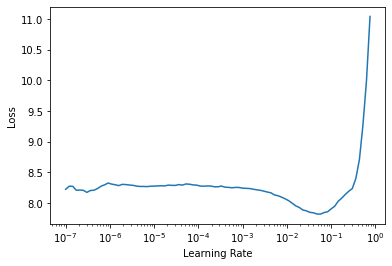

In [37]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.376186,3.871335,0.218612,0.444904,01:03
1,4.203279,3.662590,0.240473,0.496307,01:03
2,3.374423,3.024303,0.332053,0.595864,01:03
3,3.031234,2.798667,0.354801,0.646677,01:03
4,2.666882,2.504205,0.411817,0.699852,01:03
5,2.319155,2.315259,0.462629,0.727031,01:03
6,1.973224,2.094513,0.501920,0.765731,01:04
7,1.608434,1.935286,0.530281,0.797932,01:03
8,1.398510,1.883317,0.553914,0.802954,01:03
9,1.202481,1.872230,0.555096,0.805908,01:03


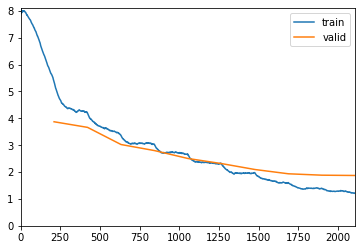

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quickresnet18.pth')

In [38]:
learn.fit_one_cycle(10, 1e-02)
learn.save('stage-1-quickresnet18')

Unfreezing model body
11,968,576 total parameters.
11,968,576 training parameters.


SuggestedLRs(lr_min=1.9054606673307718e-05, lr_steep=7.585775847473997e-07)

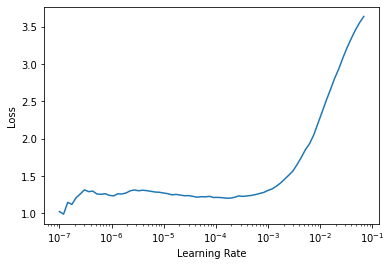

In [39]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.253325,1.872273,0.550074,0.804727,01:04
1,1.225031,1.856861,0.557755,0.807090,01:04
2,1.224061,1.837848,0.558936,0.809749,01:04
3,1.142093,1.822689,0.561595,0.814771,01:04
4,1.083736,1.804391,0.566617,0.813589,01:04
5,1.039487,1.778013,0.571640,0.817430,01:04
6,0.952541,1.773764,0.569572,0.818316,01:04
7,0.944047,1.761585,0.576366,0.820679,01:04
8,0.908789,1.754593,0.572526,0.821566,01:03
9,0.904825,1.756453,0.575480,0.823043,01:04


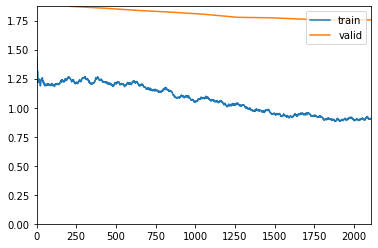

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quickresnet18.pth')

In [40]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-1-quickresnet18')

### Quick ResNet34

In [21]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           log_name = 'quickbaseline.csv')

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Freezing model body
22,076,736 total parameters.
809,088 training parameters.


SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.009120108559727669)

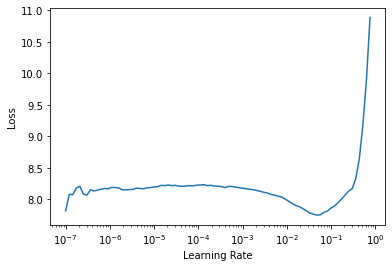

In [22]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.380674,3.862144,0.215953,0.441654,01:06
1,4.164528,3.812981,0.214771,0.472378,01:07
2,3.354764,3.130136,0.312260,0.587888,01:06
3,2.974951,2.825325,0.353028,0.641064,01:07
4,2.588697,2.559198,0.407976,0.688626,01:07
5,2.224540,2.248531,0.468242,0.744756,01:06
6,1.860929,1.997348,0.512260,0.789069,01:07
7,1.524130,1.861627,0.552142,0.813589,01:06
8,1.315566,1.790887,0.565140,0.818316,01:06
9,1.108867,1.784061,0.572230,0.823929,01:06


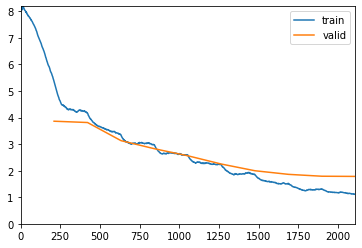

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quickbaseline.pth')

In [23]:
learn.fit_one_cycle(10, 1e-02)
learn.save('stage-1-quickbaseline')

Unfreezing model body
22,076,736 total parameters.
22,076,736 training parameters.


SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=1.3182567499825382e-06)

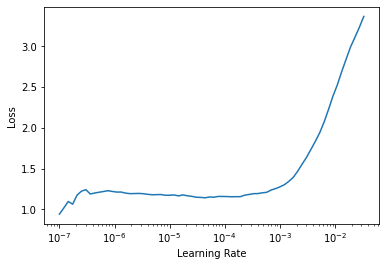

In [24]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.169512,1.779867,0.571640,0.819793,01:09
1,1.170363,1.783885,0.569867,0.821270,01:08
2,1.154361,1.760865,0.573412,0.825406,01:09
3,1.079567,1.747816,0.580207,0.825702,01:08
4,0.999833,1.719440,0.581388,0.827474,01:08
5,0.910574,1.690382,0.584343,0.831019,01:08
6,0.852735,1.679179,0.594682,0.835451,01:07
7,0.820240,1.662708,0.598818,0.839586,01:08
8,0.768614,1.655415,0.597341,0.839586,01:08
9,0.762076,1.656761,0.597046,0.840177,01:08


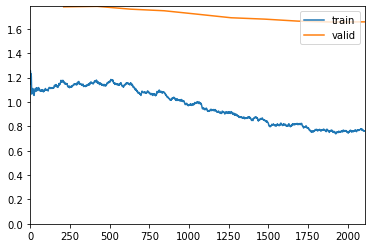

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quickbaseline.pth')

In [25]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quickbaseline')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.789546,1.651657,0.595864,0.840177,01:08
1,0.822559,1.686037,0.591728,0.837814,01:07
2,0.830991,1.679663,0.593205,0.833087,01:07
3,0.796793,1.672298,0.597932,0.836041,01:06
4,0.744889,1.660933,0.598523,0.835451,01:07
5,0.709819,1.647272,0.600591,0.843722,01:07
6,0.655534,1.638553,0.600295,0.845199,01:07
7,0.598438,1.632686,0.605022,0.845790,01:08
8,0.588223,1.625510,0.605318,0.844904,01:07
9,0.579358,1.630201,0.607681,0.845199,01:08


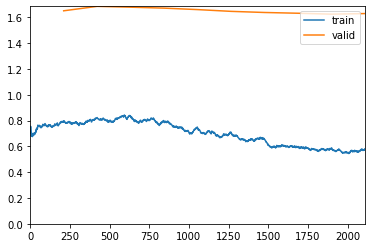

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-3-quickbaseline.pth')

In [26]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-3-quickbaseline')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.581178,1.629941,0.602068,0.844609,01:07
1,0.611442,1.659820,0.600886,0.840473,01:07
2,0.665524,1.693376,0.591433,0.838405,01:07
3,0.617467,1.680925,0.592614,0.839586,01:07
4,0.578127,1.658810,0.604136,0.847858,01:07
5,0.510131,1.644334,0.604136,0.842245,01:08
6,0.472106,1.641933,0.604727,0.846972,01:07
7,0.442126,1.625005,0.607386,0.850222,01:07
8,0.424646,1.624912,0.609749,0.848744,01:08
9,0.420558,1.619842,0.610931,0.847563,01:07


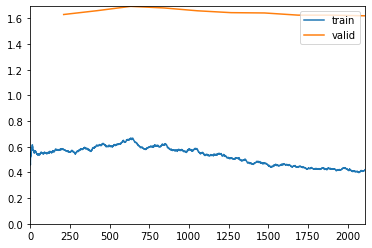

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-4-quickbaseline.pth')

In [27]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-4-quickbaseline')

### Quick Resnet50

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           log_name = 'quickresnet50.csv', 
                           arch='resnet50')

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Freezing model body
25,879,104 total parameters.
2,424,192 training parameters.


SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.010964781977236271)

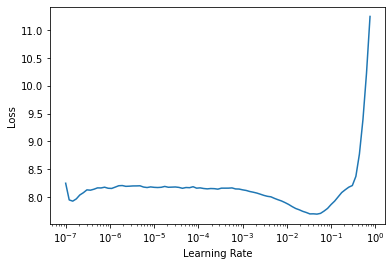

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.841085,3.629766,0.254653,0.501329,01:07
1,4.102129,3.951435,0.209453,0.459380,01:07
2,3.266984,3.014024,0.332939,0.606499,01:07
3,2.838333,3.158679,0.304284,0.593501,01:08
4,2.489719,2.522846,0.404136,0.703397,01:07
5,2.056407,2.154622,0.481832,0.761300,01:08
6,1.621702,1.876814,0.532053,0.802068,01:08
7,1.248830,1.730972,0.570162,0.831905,01:08
8,0.998498,1.649505,0.594978,0.835155,01:08
9,0.845647,1.636713,0.597932,0.837223,01:08


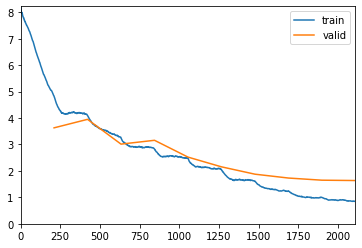

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-resnet50.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-02)
learn.save('stage-1-quick-resnet50')

Unfreezing model body
25,879,104 total parameters.
25,879,104 training parameters.


SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=9.12010818865383e-07)

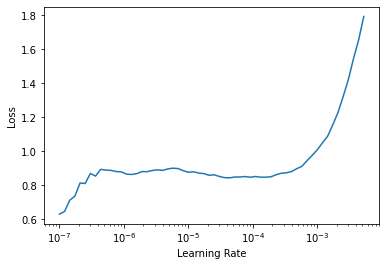

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.861795,1.638012,0.593205,0.842836,01:20
1,0.877957,1.643481,0.593501,0.844609,01:20
2,0.872858,1.640017,0.591728,0.844904,01:21
3,0.818900,1.614497,0.602068,0.845495,01:21
4,0.737809,1.597066,0.605318,0.849926,01:21
5,0.672943,1.575761,0.608863,0.853176,01:21
6,0.623661,1.571752,0.611817,0.854357,01:21
7,0.568811,1.560181,0.615066,0.854653,01:21
8,0.539619,1.553146,0.613294,0.855539,01:21
9,0.527328,1.552151,0.613589,0.858198,01:21


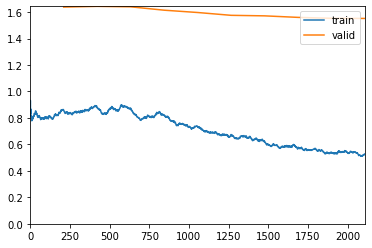

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-resnet50.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-resnet50')

### Quick Resnet101

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           log_name = 'quickresnet101.csv', 
                           arch='resnet101')

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Freezing model body
44,871,232 total parameters.
2,476,416 training parameters.


SuggestedLRs(lr_min=0.004786301031708717, lr_steep=9.12010818865383e-07)

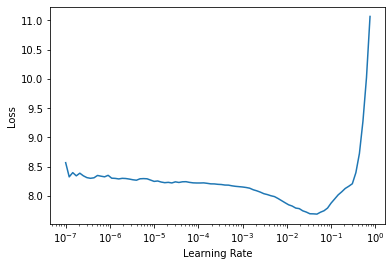

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.763552,3.647169,0.238109,0.481241,01:36
1,4.157120,4.194188,0.193796,0.440177,01:35
2,3.299127,3.108125,0.298966,0.584047,01:35
3,2.888129,2.976003,0.328508,0.624225,01:35
4,2.510884,2.631183,0.392614,0.684490,01:35
5,2.051521,2.157021,0.491876,0.762777,01:35
6,1.656881,1.986550,0.516691,0.793796,01:35
7,1.265091,1.732461,0.575185,0.831315,01:35
8,1.026240,1.644695,0.602659,0.844904,01:36
9,0.842179,1.630958,0.601773,0.845790,01:35


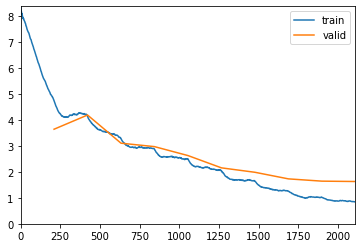

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-resnet101.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-02)
learn.save('stage-1-quick-resnet101')

Unfreezing model body
44,871,232 total parameters.
44,871,232 training parameters.


SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=7.585775847473997e-07)

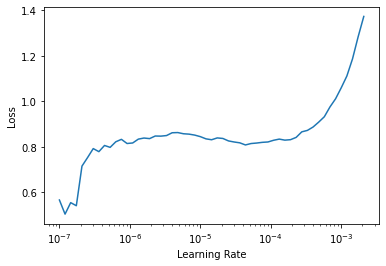

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.877971,1.634380,0.604136,0.849631,02:01
1,0.880052,1.679194,0.592024,0.840177,02:01
2,0.898091,1.657956,0.590842,0.841359,02:02
3,0.845806,1.629556,0.597341,0.843722,02:02
4,0.764003,1.597111,0.610340,0.846381,02:02
5,0.678277,1.567661,0.614180,0.857607,02:01
6,0.600276,1.553793,0.623929,0.857607,02:01
7,0.567100,1.534099,0.625111,0.859084,02:01
8,0.535078,1.529610,0.626292,0.861448,02:01
9,0.517469,1.524259,0.627179,0.862334,02:01


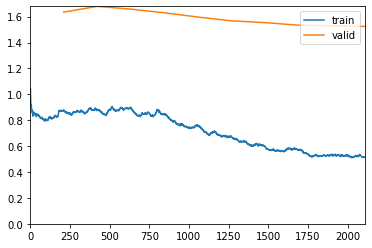

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-resnet101.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-resnet101')

### Quick Resnet152

In [41]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           log_name = 'quickresnet101.csv', 
                           arch='resnet152')

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


Freezing model body
60,514,880 total parameters.
2,522,496 training parameters.


SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.005248074419796467)

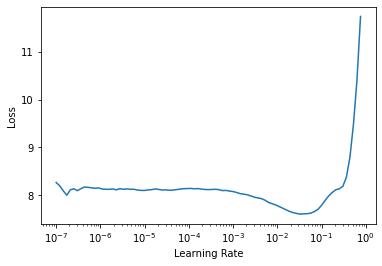

In [42]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.799128,3.724181,0.238996,0.471196,02:07
1,4.120324,4.810383,0.154210,0.352733,02:07
2,3.285042,3.348911,0.275923,0.552142,02:07
3,2.824930,2.889234,0.330871,0.629542,02:07
4,2.475958,2.580218,0.405318,0.680650,02:07
5,2.041909,2.134550,0.489808,0.768390,02:08
6,1.648453,1.889895,0.536484,0.807681,02:08
7,1.208896,1.703043,0.581684,0.838109,02:08
8,0.984141,1.624222,0.603250,0.849335,02:07
9,0.829259,1.608792,0.603840,0.853471,02:08


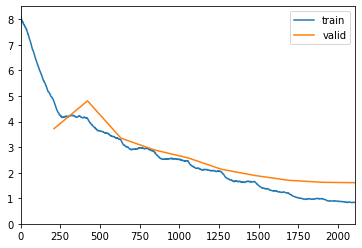

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-resnet152.pth')

In [43]:
learn.fit_one_cycle(10, 1e-02)
learn.save('stage-1-quick-resnet152')

Unfreezing model body
60,514,880 total parameters.
60,514,880 training parameters.


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=7.585775847473997e-07)

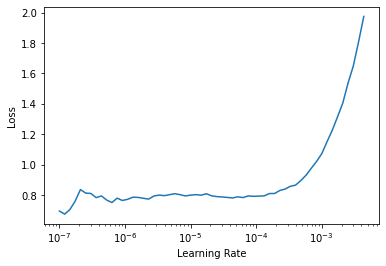

In [44]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.844308,1.611323,0.605022,0.849335,02:45
1,0.904222,1.672938,0.586706,0.841654,02:44
2,0.902256,1.676822,0.580207,0.839586,02:44
3,0.853559,1.630254,0.599705,0.848744,02:44
4,0.753349,1.596496,0.607386,0.853176,02:44
5,0.668108,1.558501,0.611226,0.855539,02:44
6,0.598716,1.545720,0.618907,0.859380,02:44
7,0.536063,1.528448,0.616544,0.861448,02:44
8,0.501012,1.523646,0.615066,0.863811,02:44
9,0.495243,1.517921,0.618021,0.864402,02:44


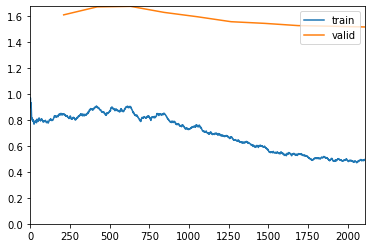

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-resnet152.pth')

In [45]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-resnet152')

### Quick Resnet34 - 448px

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=448, 
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           log_name = 'quickbaseline_448px.csv')

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
22,076,736 total parameters.
809,088 training parameters.


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.010964781977236271)

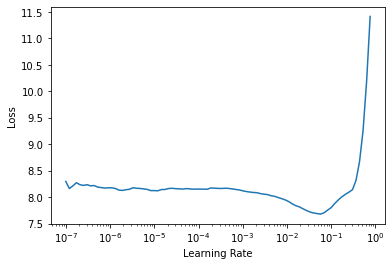

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.292181,3.751250,0.225997,0.464402,01:52
1,4.009425,3.554969,0.259970,0.502511,01:53
2,3.201278,2.923901,0.357459,0.622747,01:53
3,2.787172,2.604293,0.393796,0.683013,01:52
4,2.404189,2.474571,0.437223,0.708124,01:52
5,2.048426,2.079883,0.512851,0.773412,01:53
6,1.687058,1.831584,0.552437,0.819498,01:53
7,1.320713,1.683838,0.599409,0.840177,01:53
8,1.109586,1.616789,0.607681,0.850517,01:52
9,0.950999,1.608150,0.610340,0.854653,01:53


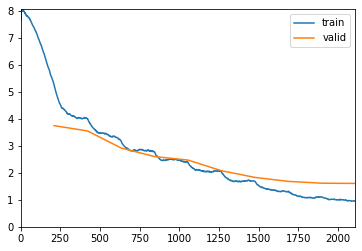

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quickbaseline-448px.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-02)
learn.save('stage-1-quickbaseline-448px')

Unfreezing model body
22,076,736 total parameters.
22,076,736 training parameters.


SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=7.585775847473997e-07)

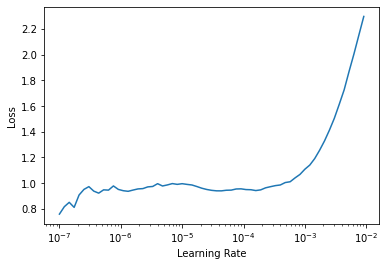

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.985053,1.607244,0.613294,0.850812,02:30
1,0.993009,1.627172,0.613885,0.848744,02:31
2,1.008064,1.608149,0.608863,0.849926,02:31
3,0.921860,1.585556,0.615657,0.852880,02:31
4,0.839203,1.562396,0.624225,0.857016,02:31
5,0.748415,1.533355,0.626292,0.861743,02:31
6,0.743582,1.536822,0.631019,0.859084,02:31
7,0.665574,1.513259,0.632792,0.862334,02:31
8,0.658676,1.510013,0.635746,0.864993,02:31
9,0.638493,1.507260,0.636337,0.862925,02:31


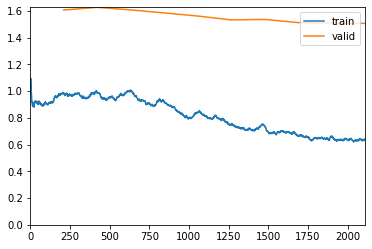

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quickbaseline-448px.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quickbaseline-448px')

## Quick XResNet

> Poor performance, likely due to quality of pretrained weights.

In [ ]:
# Import the xresnet models
from fastai.vision.models.xresnet import *

### Quick XResNet


* XResNet - Based on the Bag of Tricks for Resnet paper
* Mish - A new activation function that has shown fantastic results
* Ranger - A new optimizer function based on two seperate papers:
  * On the Varience of the Adaptive Learning rate and Beyond, RAdam
  * Lookahead Optimizer: k steps forward, 1 step back
* Self-Attention - Bringing in ideas from GAN's into image classification 
* Flatten + Anneal Scheduling - Mikhail Grankin
* Label Smoothing Cross Entropy - A threshold base (were you close) rather than yes or no

In [ ]:
if ('xresnet' in arch) and act_cls != 'ReLU':
  model = partial(model, act_cls=act_cls, sa=sa, n_out=dls.c)
elif 'xresnet' in arch:
  model = partial(model, sa=sa, n_out=dls.c)

In [ ]:
learn = create_cnn_learner(pct_images=0.25,
                           deterministic=True,  
                           arch='xresnet50', 
                           size=224, 
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           log_name = 'xresnet50.csv',
                           bs=64,
                           pretrained=True
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/hub/checkpoints/xrn50_940.pth


Freezing model body
25,898,336 total parameters.
2,424,320 training parameters.


SuggestedLRs(lr_min=0.002290867641568184, lr_steep=0.005248074419796467)

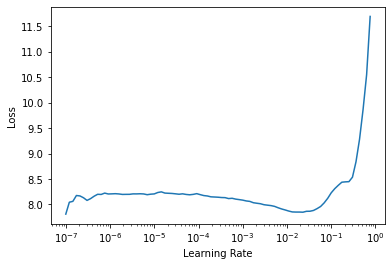

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,6.363160,5.429543,0.057016,0.163663,01:06
1,5.355260,4.755956,0.097784,0.246677,01:07
2,4.580175,4.317061,0.142393,0.342984,01:06
3,4.220543,4.045034,0.174003,0.392910,01:06
4,3.839763,3.760348,0.203840,0.449631,01:06
5,3.533624,3.518166,0.253767,0.510487,01:06
6,3.183973,3.334555,0.281832,0.543279,01:06
7,2.831918,3.173747,0.316100,0.575480,01:06
8,2.564847,3.097710,0.327031,0.587592,01:06
9,2.369013,3.086977,0.326440,0.589069,01:07


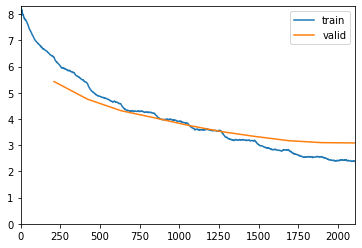

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-xresnet50.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-xresnet50')

Unfreezing model body
25,898,336 total parameters.
25,898,336 training parameters.


SuggestedLRs(lr_min=1.9054606673307718e-05, lr_steep=1.9054607491852948e-06)

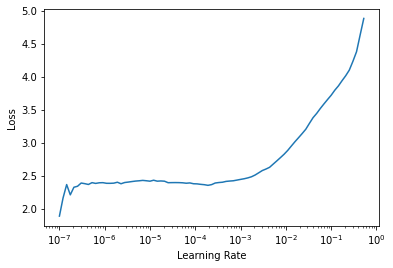

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.398705,3.083523,0.330871,0.589956,01:20
1,2.386346,3.068331,0.332939,0.594387,01:20
2,2.330010,3.058271,0.333235,0.595864,01:20
3,2.340703,3.040931,0.335303,0.598818,01:20
4,2.304447,3.037189,0.341211,0.603545,01:20
5,2.269883,3.021683,0.345643,0.601477,01:20
6,2.229787,3.021473,0.342984,0.606795,01:20
7,2.241567,3.019022,0.346824,0.606204,01:20
8,2.242438,3.006408,0.345938,0.607681,01:20
9,2.258759,3.012908,0.347120,0.607681,01:20


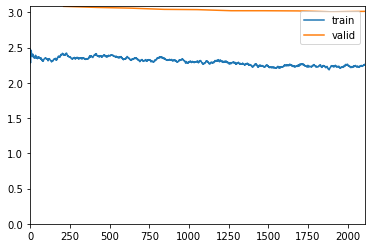

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-xresnet50.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-xresnet50')

### SOTA xResnet

* XResNet - Based on the Bag of Tricks for Resnet paper

In [ ]:
printm()

Gen RAM Free: 26.1 GB  | Proc size: 303.2 MB
GPU RAM Free: 16120MB | Used: 10MB | Util   0% | Total 16130MB


In [ ]:
learn = create_cnn_learner(pct_images=0.25,
                           deterministic=True,  
                           arch='xresnet50', 
                           act_cls=Mish, 
                           sa=True, 
                           loss_func=LabelSmoothingCrossEntropy(),
                           size=224, 
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           log_name = 'xresnet50_sota.csv',
                           bs=56, #60 is too many
                           pretrained=True
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/hub/checkpoints/xrn50_940.pth


Freezing model body
25,963,873 total parameters.
2,424,320 training parameters.


SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=2.75422871709452e-06)

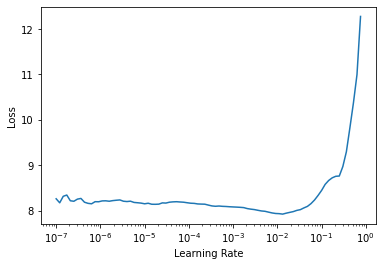

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,6.737947,5.911587,0.038996,0.123191,01:17
1,5.634314,5.161563,0.079764,0.225111,01:17
2,4.961504,4.744925,0.128804,0.314919,01:17
3,4.679482,4.501132,0.167208,0.385524,01:17
4,4.381416,4.314567,0.194092,0.442836,01:17
5,4.071916,4.087054,0.241654,0.502806,01:18
6,3.842650,3.866076,0.285967,0.554801,01:17
7,3.530564,3.742130,0.319941,0.577253,01:17
8,3.334864,3.699803,0.334417,0.593501,01:17
9,3.171216,3.692502,0.334417,0.590547,01:17


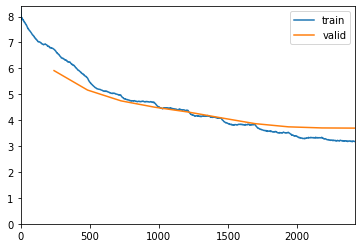

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-xresnet50-sota.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-xresnet50-sota')

Unfreezing model body
25,963,873 total parameters.
25,963,873 training parameters.


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.309573450380412e-07)

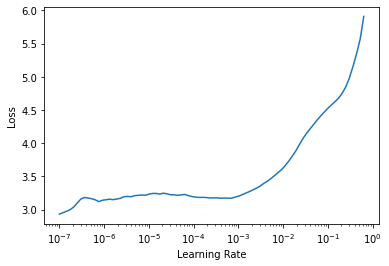

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.217570,3.685616,0.337962,0.590842,01:35
1,3.167722,3.676413,0.336189,0.595864,01:35
2,3.177233,3.669021,0.335007,0.594682,01:35
3,3.135299,3.643317,0.343870,0.600295,01:35
4,3.131316,3.642608,0.346529,0.605613,01:35
5,3.089329,3.628105,0.355096,0.607976,01:35
6,3.066456,3.629627,0.351846,0.606795,01:35
7,3.066684,3.625455,0.349778,0.608272,01:35
8,3.061377,3.621203,0.349483,0.609453,01:35
9,3.101516,3.621573,0.352733,0.608272,01:35


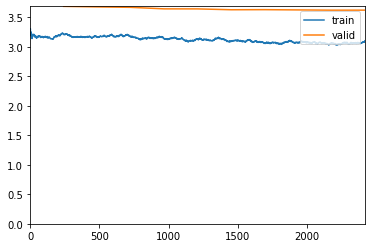

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-xresnet50-sota.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-xresnet50-sota')

### efficientnet_b3

In [30]:
def efficientnet_b3(pretrained = False):
  model = geffnet.efficientnet_b3(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True)
  return model

In [31]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'efficientnet_b3',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


Freezing model body
12,540,968 total parameters.
1,932,032 training parameters.


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=9.12010818865383e-07)

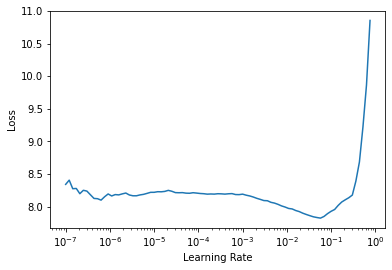

In [32]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.733222,4.163244,0.179616,0.394978,01:12
1,4.080531,3.173712,0.313442,0.583456,01:12
2,3.107243,2.568545,0.422452,0.683604,01:12
3,2.590458,2.211445,0.472083,0.751551,01:12
4,2.198409,2.035316,0.519055,0.776366,01:12
5,1.769597,1.838791,0.555687,0.817430,01:12
6,1.385136,1.701008,0.586411,0.834564,01:12
7,1.073498,1.628855,0.601182,0.847267,01:12
8,0.865583,1.608882,0.610044,0.850812,01:12
9,0.756063,1.595218,0.617134,0.854357,01:12


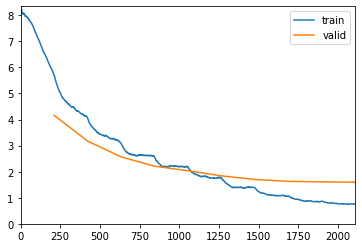

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-geffnet-tf_efficientnet_b3.pth')

In [33]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-geffnet-tf_efficientnet_b3')

Unfreezing model body
12,540,968 total parameters.
12,540,968 training parameters.


SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=7.585775847473997e-07)

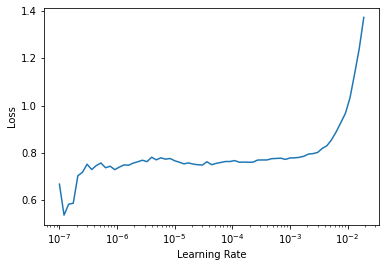

In [34]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.773445,1.605855,0.615066,0.854062,01:31
1,0.726780,1.593315,0.618021,0.854653,01:31
2,0.729115,1.585041,0.615362,0.854062,01:31
3,0.713414,1.587736,0.616839,0.855835,01:32
4,0.706981,1.591856,0.616839,0.854948,01:31
5,0.670050,1.582651,0.621270,0.859380,01:31
6,0.693324,1.583791,0.620679,0.857607,01:31
7,0.683829,1.583646,0.621270,0.859675,01:31
8,0.654749,1.580604,0.621566,0.860266,01:32
9,0.660675,1.578963,0.618021,0.859380,01:31


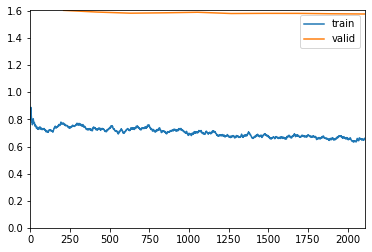

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-geffnet-tf_efficientnet_b3.pth')

In [35]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-geffnet-tf_efficientnet_b3')